# Todo


- Implement algorithm
- Explore multiple dataset generation approach
- Show results (mayve some data visualization ?)
- Compare the "graph baseline" with traditional kernel methods

In [44]:
import numpy as np
import pygsp
import ruptures as rpt
import matplotlib.pyplot as plt

SEED = 6326572
np.random.seed(SEED)

# Dataset

In [52]:
# Params
n_nodes = 500
p = 0.3
mean_exponential = 50
mean_change_points = 5
random_freq = 20

def generate_erdos_renyi(
        n_nodes,
        p,
        mean_exponential=50,
        mean_change_points=5,
        random_freq=20
    ):
    # Generate Graph Structure
    G = pygsp.graphs.ErdosRenyi(N=n_nodes, p=p, seed=SEED)
    G.set_coordinates()
    G.compute_fourier_basis()

    spectral_profile = lambda x: np.sqrt(15)/(np.log(x+10)+1)
    H = pygsp.filters.Filter(G, lambda x: spectral_profile(x))
    PSD = (spectral_profile(G.e))**2

    # Generate Signals
    n_bkps = np.random.poisson(lam=mean_change_points)
    bkps = []
    mus = []
    signals = []
    
    acc_bkp = 0
    acc_mean = np.zeros((n_nodes,1))
    for bkpt in range(n_bkps):
        # Get new segment mean
        subset_freq = np.random.choice(range(n_nodes), size=random_freq, replace=False)
        acc_mean[subset_freq] = np.random.uniform(-5.0,5.0,size=(random_freq,1))

        # Generate segment
        segment_length = int(np.random.exponential(scale=mean_exponential)+30)
        acc_bkp += segment_length
        signal = np.random.normal(size=(n_nodes,segment_length))
        signal = H.filter(signal) + G.U @ acc_mean
        # Record bkp position, mean and signal
        bkps.append(acc_bkp)
        mus.append(np.copy(acc_mean))
        signals.append(signal)
    signal = np.concatenate(signals, 1)
    return G, PSD, bkps, mus, signal
    
G, PSD, bkps, mus, signal = generate_erdos_renyi(n_nodes,p,mean_exponential,mean_change_points,random_freq)

7 changes points


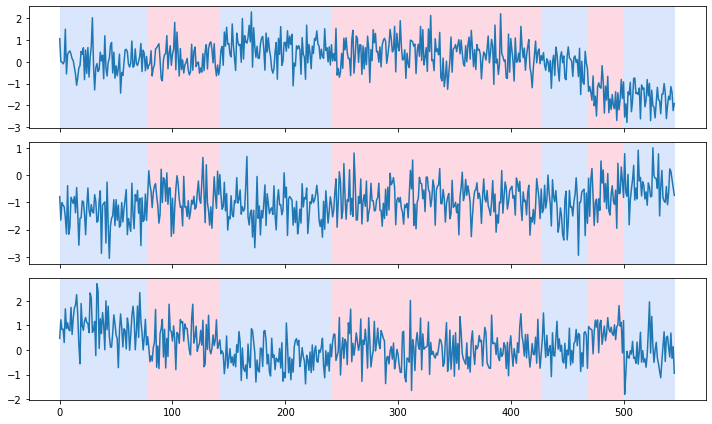

In [53]:
print(f'{len(bkps)} changes points')
rpt.show.display(signal[:3].T, bkps);

# LGS

# VSGS